In [1]:
import os
import re
import numpy as np
import pandas as pd
import random
import scipy
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

# Protocol

The whole protocol mainly includes four steps:

* (1) prepare the dataset (demo)
* (2) microbial prior knowledge network (SparCC)
* (3) microbial interaction network construction by causal inference
* (4) keystone species identification by dynamic intervention simulation

# Step 1. prepare the dataset

Here we use the demo dataset (in "./Demo/"), including 10 control samples ("Demo/AGP_control_abundance_1.tsv") and 10 disease samples ("Demo/AGP_cancer_abundance_1.tsv"), and contains the abundance values of 20 genus.

In [2]:
control = pd.read_csv('Demo/AGP_control_abundance_1.tsv', sep='\t', index_col=0)
control.shape
control.head()

(20, 10)

,10317.000038095,10317.000039830,10317.000038456,10317.000038060,10317.000038039,10317.000038099,10317.000012267,10317.000037927,10317.000038192,10317.000038246
#OTU ID,,,,,,,,,,
Bacteroides,0.417069,0.297211,0.363855,0.099673,0.708636,0.131107,0.355519,0.276527,0.004045,0.279051
Faecalibacterium,0.137681,0.031076,0.065060,0.040033,0.023406,0.176710,0.064123,0.150322,0.019417,0.099018
Prevotella,0.002415,0.000000,0.000000,0.000000,0.000000,0.043974,0.017857,0.000000,0.101942,0.000000
Roseburia,0.024960,0.006375,0.118876,0.040033,0.026634,0.095277,0.070617,0.086013,0.009709,0.022913
Parabacteroides,0.017713,0.038247,0.037751,0.021242,0.017756,0.008958,0.015422,0.013666,0.000809,0.030278


In [3]:
disease = pd.read_csv('Demo/AGP_cancer_abundance_1.tsv', sep='\t', index_col=0)
disease.shape
disease.head()

(20, 10)

,10317.000038240,10317.000037546,10317.000038304,10317.000039690,10317.000039673,10317.000039553,10317.000036170,10317.000039645,10317.000037543,10317.000039978
#OTU ID,,,,,,,,,,
Bacteroides,0.299837,0.074579,0.160572,0.468016,0.290997,0.137931,0.249194,0.661031,0.072594,0.430966
Faecalibacterium,0.098856,0.000000,0.016693,0.109312,0.040997,0.208500,0.261290,0.039452,0.081566,0.058260
Prevotella,0.000000,0.000000,0.011924,0.000000,0.000000,0.000000,0.000000,0.000000,0.003263,0.000000
Roseburia,0.056373,0.000000,0.017488,0.042105,0.070740,0.174820,0.044355,0.053140,0.144372,0.039106
Parabacteroides,0.000817,0.000000,0.022258,0.040486,0.111736,0.000802,0.024194,0.022544,0.021207,0.075020


# 2. microbial prior knowledge network (SparCC)

For causal inference, microbial prior knowledge network need to be constructed through existing microbial interaction experiments or knowledge. Here, we can use SparCC to construct microbial co-occurrence network as the microbial prior knowledge. 

The original SparCC algorithm requires a python 2.7 environment.

* (1) active python 2.7 evironment
* (2) run "python run_sparcc.py"
* (3) you can use the "fastpar" package in R to improve the speed

**run_sparcc.py:**

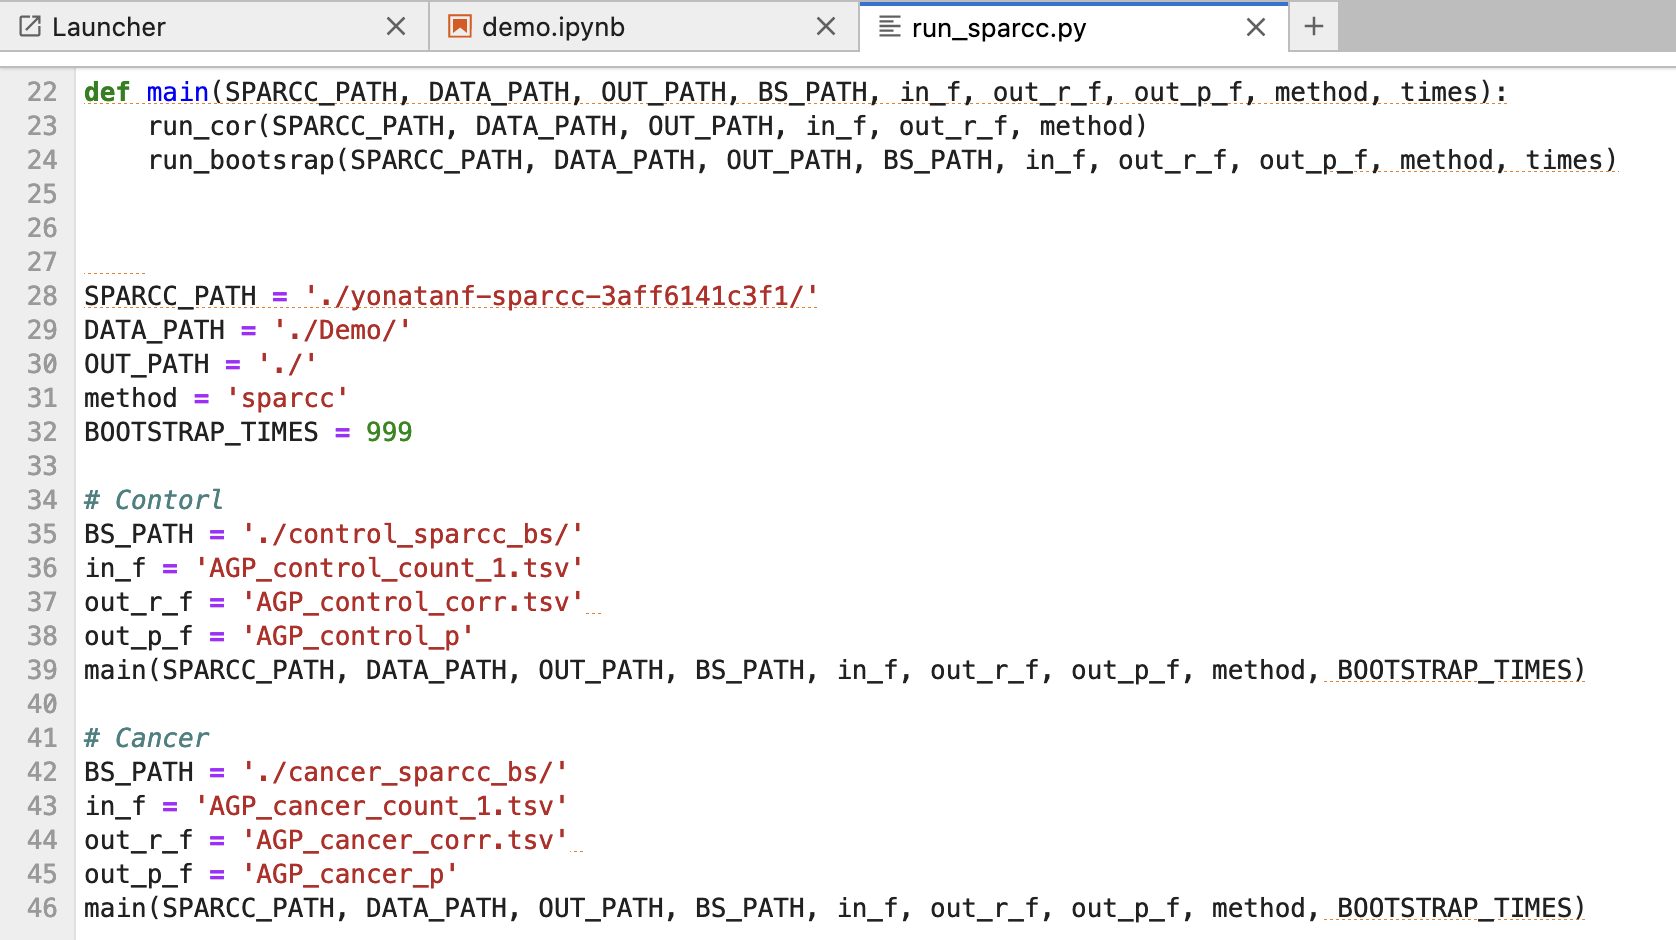

**python run_sparcc.py**
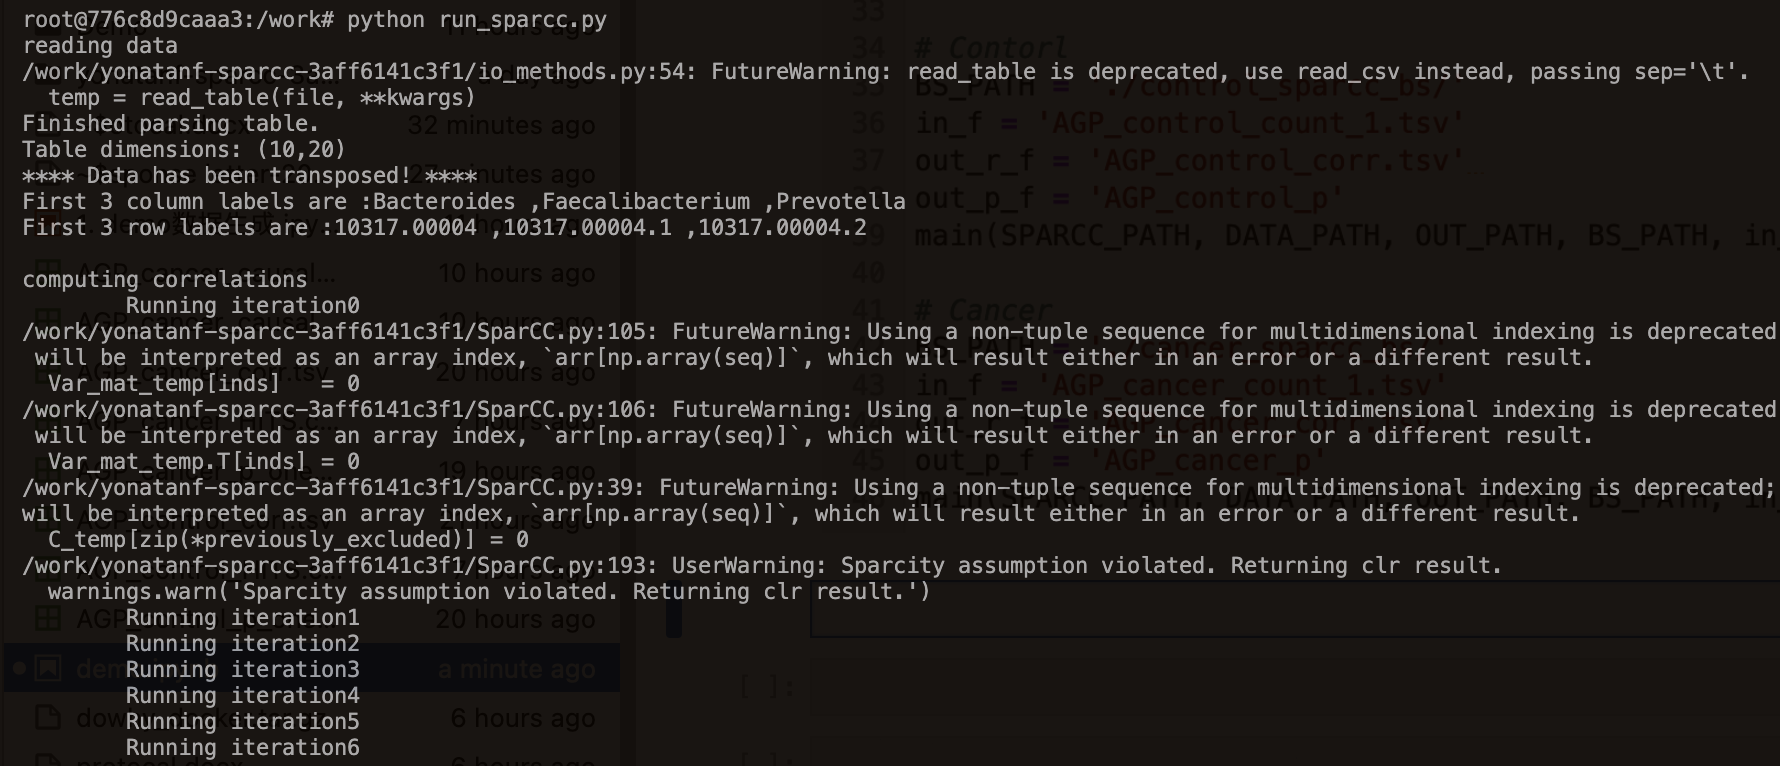

# 3. microbial interaction network construction by causal inference

Microbial interaction networks of control and disease states are constructed respectively based on causal inference (dowhy). Here we provide a Docker image with dowhy package, which could be pull from dockerhub.

* (1) active dowhy evironment 
    + docker pull ddhmed/dowhy:20221008
    + docker run -it -v $PWD:/work ddhmed/dowhy:20221008 /bin/bash
* (2) configure parameters, such as BOOTSTRAP_TIMES, MAX_STEPS, LEARNING_RATE, STRUCTURE_THRESHOLD
* (3) run "python run_causalinference.py"

**run_causalinference.py:**

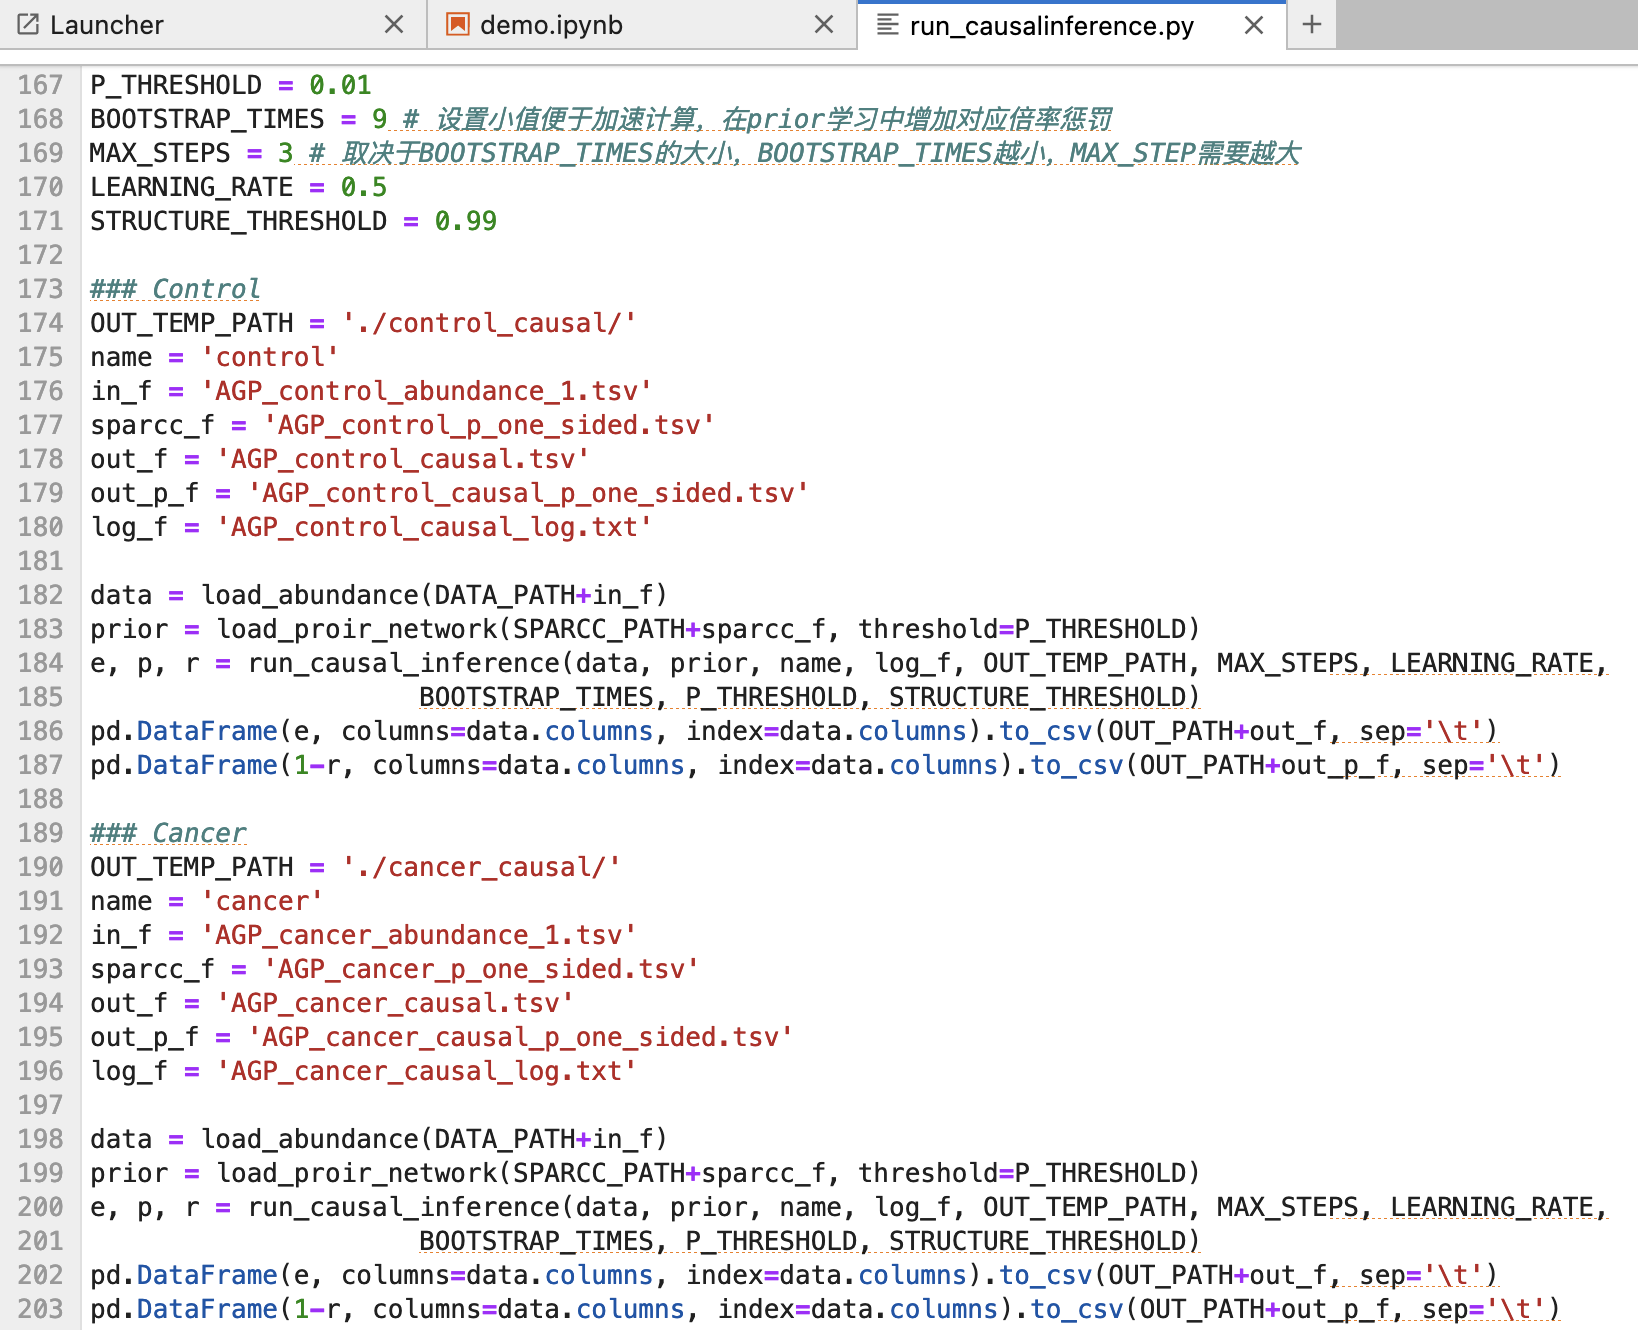

Parameters, such as BOOTSTRAP_ TIMES, MAX_ STEPS, LEARNING_ RATE, STRUCTURE_ THRESHOLD, can be configured according to the number of sample and taxon. Here we set MAX_ STEPS=3 for the demo dataset.

**python run_causalinference.py**

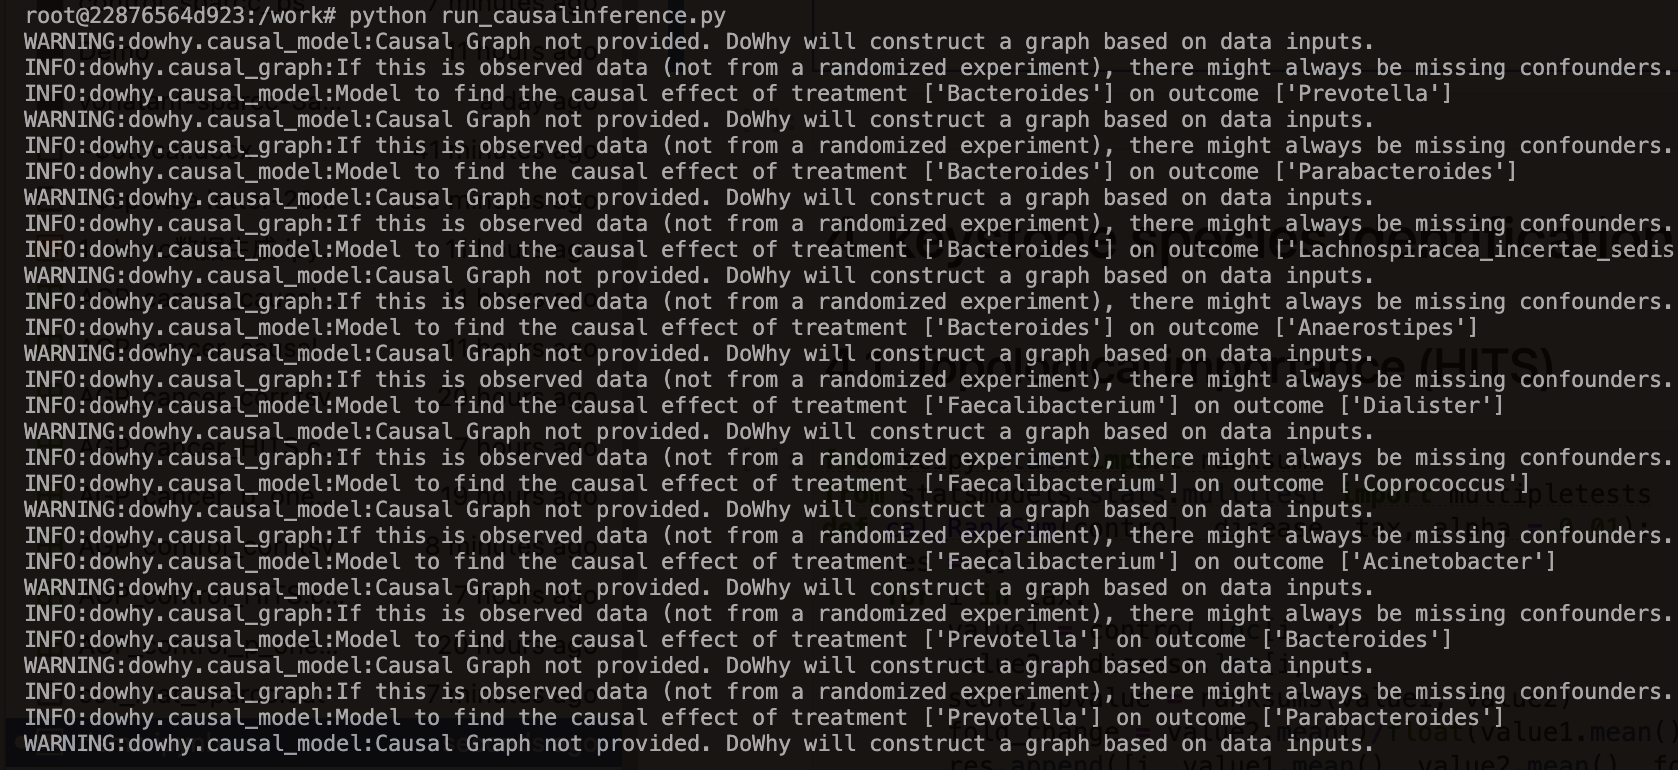

# 4. keystone species identification by dynamic intervention simulation

* (1) topological importance (HITS) is calculated by networkx package.
* (2) the intervention score and optimal intervention combination are calculated through dynamic intervention simulation.

## 4.1. Topological importance (HITS)

In [4]:
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests
def cal_RankSum(control, disease, tax, alpha = 0.01):
    res = []
    for i in tax:
        value1 = control.loc[i, :]
        value2 = disease.loc[i, :]
        score, pvalue = ranksums(value1, value2)
        fold_change = value2.mean()/float(value1.mean()) if value1.mean() else np.nan
        res.append([i, value1.mean(), value2.mean(), fold_change, score, pvalue])
    res = pd.DataFrame(res, columns=['Taxa', 'Control', 'Disease', 'FC', 'RankSum', 'p-value'])
    reject, fdr, _, _ = multipletests(list(res['p-value']), alpha=alpha, method='fdr_bh')
    res['FDR'] = fdr
    res = res.sort_values(by='FDR', ascending=True)
    res.index = range(len(res.index))
    return res

def random_Network(net):
    nodeset = list(net.nodes)
    redges = np.array([(i, j, float(v)) for i,j,v in net.edges.data('weight')])
    redges[:, 0] = [random.choice(nodeset) for i in range(len(redges))]
    redges[:, 1] = [random.choice(nodeset) for i in range(len(redges))]
    redges = [(i, j, float(v)) for i,j,v in redges]
    rnet = nx.DiGraph()
    rnet.add_nodes_from(nodeset)
    rnet.add_weighted_edges_from(redges)
    return rnet

def cal_HITS(net):
    h,a = nx.hits(net, max_iter=1000)
    return h, a

def cal_HITS_pvalue(net, h, rt=100):
    p_value = {}
    r = 0
    while(r<rt-1):
        try:
            rnet = random_Network(net)
            rh, ra = cal_HITS(rnet)
            for index in net.nodes:
                hi = h.get(index, 0)
                rhi = rh.get(index, 0)
                p_value[index] = p_value.get(index, 1)
                if rhi >= hi:
                    p_value[index] += 1
            r += 1
        except:
            pass
    for index in p_value.keys():
        p_value[index] = p_value[index]/float(rt)
    return p_value

In [5]:
tax_species = control.index
diff = cal_RankSum(control, disease, tax_species, alpha = 0.01)
diff.index = diff['Taxa']

In [6]:
p_times = 1000
### build_Network
relation = pd.read_csv('control_causal/control_ematrix_2.csv', index_col=0, sep=',')
prior = pd.read_csv('control_causal/control_pmatrix_2.csv', index_col=0, sep=',')
edges = []
nodes = []
for target in relation.index:
    nodes.append(target)
    for source in relation.columns:
        if prior.loc[target, source]>=0.9:
            effect = 1.0 #1.0, abs(float(relation.loc[target, source]))
            edges.append((source, target, effect))
net=nx.DiGraph()
net.add_nodes_from(nodes)
net.add_weighted_edges_from(edges)
h, a = cal_HITS(net)

### p-value
p_value = cal_HITS_pvalue(net, h, rt=p_times)
res = []
for i in h.keys():
    res.append([i, h[i], p_value[i], diff.loc[i, 'Control'], diff.loc[i, 'Disease'], diff.loc[i, 'p-value'], diff.loc[i, 'FDR']])
res = sorted(res, key=lambda x:x[2], reverse=True)
res = pd.DataFrame(res, columns=['Taxa', 'hits_score', 'hits_pval', 'Control', 'Disease', 'abun_pval', 'abun_fdr'])
res.sort_values('hits_pval', ascending=True).to_csv('AGP_control_HITS.csv')

/opt/conda/lib/python3.9/site-packages/networkx/algorithms/link_analysis/hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


In [7]:
### build_Network
relation = pd.read_csv('cancer_causal/cancer_ematrix_2.csv', index_col=0, sep=',')
prior = pd.read_csv('cancer_causal/cancer_pmatrix_2.csv', index_col=0, sep=',')
edges = []
nodes = []
for target in relation.index:
    nodes.append(target)
    for source in relation.columns:
        if prior.loc[target, source]>=0.9:
            effect = 1.0 #1.0, abs(float(relation.loc[target, source]))
            edges.append((source, target, effect))
net=nx.DiGraph()
net.add_nodes_from(nodes)
net.add_weighted_edges_from(edges)
h, a = cal_HITS(net)

### p-value
p_value = cal_HITS_pvalue(net, h, rt=p_times)
res = []
for i in h.keys():
    res.append([i, h[i], p_value[i], diff.loc[i, 'Control'], diff.loc[i, 'Disease'], diff.loc[i, 'p-value'], diff.loc[i, 'FDR']])
res = sorted(res, key=lambda x:x[2], reverse=True)
res = pd.DataFrame(res, columns=['Taxa', 'hits_score', 'hits_pval', 'Control', 'Disease', 'abun_pval', 'abun_fdr'])
res.sort_values('hits_pval', ascending=True).to_csv('AGP_cancer_HITS.csv')

## 4.2. Dynamic intervention simulation

In [8]:
### Find best pattern by Greedy algorithm
def get_delta_X(A, inventions, abundances, decay=0.5, max_iter=100):
    for it in range(max_iter):
        inventions += np.round(np.dot(A, inventions) * abundances * decay**(it), 5)
    return inventions

def intervention_score(abun_df, DiseaseStatus, from_state, to_state,intervention_list, decay=0.0,
                       is_overlap=False):
    A = adjacency_matrix(from_state)
    OTUs = list(A.columns)
    inventions = np.zeros(len(OTUs))
    from_abun = abun_df.loc[DiseaseStatus==from_state, OTUs].mean()
    to_abun = abun_df.loc[DiseaseStatus==to_state, OTUs].mean()
    net = build_Network(to_state)
    h, a = cal_HITS(net)
    hits_scores = np.array([h.get(i, 0.0) for i in OTUs])
    res = []
    for otu in intervention_list:
        if not is_overlap:
            inventions = np.zeros(len(OTUs))
        inventions[OTUs.index(otu)] = to_abun.loc[otu] - from_abun.loc[otu]
        dx = get_delta_X(A, inventions, from_abun, decay, max_iter=100)
        score = (np.sign(dx * (to_abun-from_abun)) * hits_scores).sum()
        res.append([intervention_list.index(otu), otu, score])
    res = pd.DataFrame(res, columns=['Index', 'OTU', 'Score'])
    return res

### adjacency_matrix
A = pd.read_csv('cancer_causal/cancer_ematrix_2.csv', index_col=0, sep=',')
prior = pd.read_csv('cancer_causal/cancer_pmatrix_2.csv', index_col=0, sep=',')
A *= (prior>=0.9)
#A

### change from disease to normal
OTUs = list(A.columns)
inventions = np.zeros(len(OTUs))
from_abun = disease.loc[OTUs, :].mean(1)
to_abun = control.loc[OTUs, :].mean(1)
relation = pd.read_csv('control_causal/control_ematrix_2.csv', index_col=0, sep=',')
prior = pd.read_csv('control_causal/control_pmatrix_2.csv', index_col=0, sep=',')
edges = []
nodes = []
for target in relation.index:
    nodes.append(target)
    for source in relation.columns:
        if prior.loc[target, source]>=0.9:
            effect = 1.0 #1.0, abs(float(relation.loc[target, source]))
            edges.append((source, target, effect))
net=nx.DiGraph()
net.add_nodes_from(nodes)
net.add_weighted_edges_from(edges)
h, a = cal_HITS(net)
hits_scores = np.array([h.get(i, 0.0) for i in OTUs])
#hits_scores

### single otu score
single_score = []
for otu in OTUs:
    inventions = np.zeros(len(OTUs))
    inventions[OTUs.index(otu)] = to_abun.loc[otu] - from_abun.loc[otu]
    dx = get_delta_X(A, inventions, from_abun, decay=0.0, max_iter=100)
    score = (np.sign(dx * (to_abun-from_abun)) * hits_scores).sum()
    single_score.append([otu, score])

### combine otu score by greedy search
current = []
best_scores = []
best_list = list(OTUs)
final_best = []
inventions = np.zeros(len(OTUs))
for i in OTUs:
    inventions[OTUs.index(i)] = to_abun.loc[i] - from_abun.loc[i]
dx = get_delta_X(A, inventions, from_abun, decay=0.0, max_iter=100)
allscore = (np.sign(dx * (to_abun-from_abun)) * hits_scores).sum()
best_scores.append(allscore)
while(len(best_list)>0):
    res = []
    for otu in best_list:
        current = list(best_list)
        current.remove(otu)
        # invention score
        inventions = np.zeros(len(OTUs))
        for i in current:
            inventions[OTUs.index(i)] = to_abun.loc[i] - from_abun.loc[i]
        dx = get_delta_X(A, inventions, from_abun, decay=0.0, max_iter=100)
        score = (np.sign(dx * (to_abun-from_abun)) * hits_scores).sum()
        res.append([otu, score])
    res = sorted(res, key=lambda x:x[1], reverse=True)
    best_list.remove(res[0][0])
    best_scores.append(res[0][1])
    final_best.append(res[0][0])

### result
disease_hits = pd.read_csv('AGP_cancer_HITS.csv', index_col=0).sort_values('hits_pval')
disease_hits.index = disease_hits['Taxa']
contorl_hits = pd.read_csv('AGP_control_HITS.csv', index_col=0).sort_values('hits_pval')
contorl_hits.index = contorl_hits['Taxa']

best_list = final_best[::-1]
res = contorl_hits.loc[best_list, ['Taxa', 'Control', 'Disease', 'abun_pval', 'abun_fdr', 'hits_score', 'hits_pval']]
res.columns = ['Taxa', 'Control', 'Disease', 'abun_pval', 'abun_fdr', 'control_hits_score', 'control_hits_pval']
res['disease_hits_score'] = disease_hits.loc[best_list, 'hits_score']
res['disease_hits_pval'] = disease_hits.loc[best_list, 'hits_pval']
res = res.loc[best_list, :]
res['control_rank'] = [list(contorl_hits['Taxa']).index(i) for i in best_list]
res['disease_rank'] = [list(disease_hits['Taxa']).index(i) for i in best_list]
res['IS'] = [dict(single_score)[i] for i in best_list] # intervention_score
res['CIS'] = best_scores[:-1][::-1] # Cumulative_intervention_score
res

/opt/conda/lib/python3.9/site-packages/networkx/algorithms/link_analysis/hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


,Taxa,Control,Disease,abun_pval,abun_fdr,control_hits_score,control_hits_pval,disease_hits_score,disease_hits_pval,control_rank,disease_rank,IS,CIS
Taxa,,,,,,,,,,,,,
Anaerostipes,Anaerostipes,0.002907,0.006991,0.049366,0.348212,1.666667e-01,0.003,5.711024e-20,0.991,3,12,1.666667e-01,0.166667
Clostridium_XVIII,Clostridium_XVIII,0.003896,0.003133,0.879829,1.000000,1.666667e-01,0.003,1.111111e-01,0.016,4,2,1.666667e-01,0.333333
Lachnospiracea_incertae_sedis,Lachnospiracea_incertae_sedis,0.004860,0.004434,0.733730,1.000000,1.666667e-01,0.004,1.111111e-01,0.018,5,6,1.666667e-01,0.500000
Parabacteroides,Parabacteroides,0.020184,0.031906,0.545350,0.991545,1.666667e-01,0.001,1.111111e-01,0.020,0,7,1.666667e-01,0.666667
Prevotella,Prevotella,0.016619,0.001519,0.364346,0.901509,1.666667e-01,0.001,0.000000e+00,1.000,1,18,1.666667e-01,0.833333
Bacteroides,Bacteroides,0.293270,0.284572,0.939743,1.000000,1.666667e-01,0.002,0.000000e+00,1.000,2,19,1.666667e-01,1.000000
Acinetobacter,Acinetobacter,0.000000,0.000000,1.000000,1.000000,-4.904824e-17,1.000,1.111111e-01,0.017,14,3,0.000000e+00,1.000000
Phascolarctobacterium,Phascolarctobacterium,0.002683,0.011304,0.173617,0.578724,-7.868865e-20,0.999,1.111111e-01,0.014,12,1,7.868865e-20,1.000000
Coprococcus,Coprococcus,0.012476,0.003314,0.307489,0.878541,-4.904824e-17,1.000,0.000000e+00,1.000,15,14,-3.462301e-17,1.000000


## 4.3. Intervention simulation result

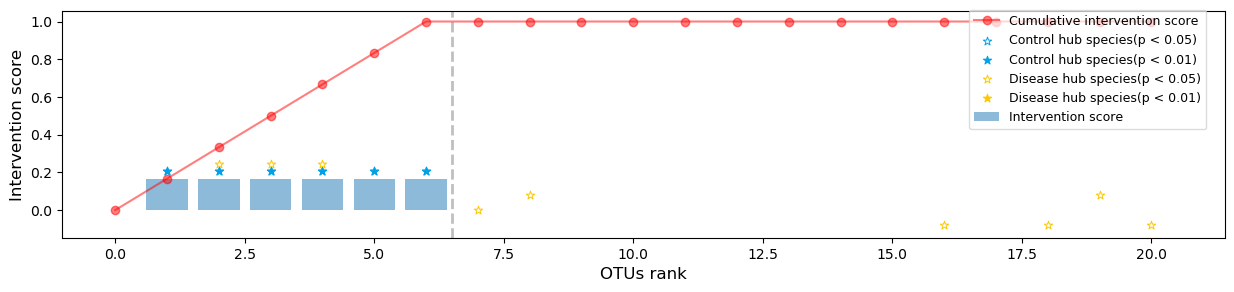

In [9]:
_ = plt.figure(1, (15, 3), dpi=100)
_ = plt.bar(range(1, len(res.index)+1), res['IS'], label='Intervention score', alpha=0.5)
cis = [0]
cis.extend(res['CIS'])
_ = plt.plot(range(0, len(res.index)+1), cis, 'r-', marker='o', label='Cumulative intervention score', alpha=0.5)

control_keystone = np.array([i for i in range(len(res.index)) if list(res['control_hits_pval'])[i]<=0.05])
y_loc = np.array(res['IS'])[control_keystone]
fdr001 = [True if i<=0.01 else False for i in np.array(res['control_hits_pval'])[control_keystone]]
fdr001 = [i for i in range(len(fdr001)) if fdr001[i]]
_ = plt.scatter(control_keystone+1, y_loc+np.sign(y_loc)*0.04, marker='*', s=40,
                color='#00a1e9', facecolors='white', lw=0.7, label='Control hub species(p < 0.05)')
_ = plt.scatter(control_keystone[fdr001]+1, y_loc[fdr001]+np.sign(y_loc[fdr001])*0.04, marker='*', s=40,
                color='#00a1e9', facecolors='#00a1e9', lw=0.7, label='Control hub species(p < 0.01)')


disease_keystone = np.array([i for i in range(len(res.index)) if list(res['disease_hits_pval'])[i]<=0.05])
y_loc = np.array(res['IS'])[disease_keystone]
fdr001 = [True if i<=0.01 else False for i in np.array(res['disease_hits_pval'])[disease_keystone]]
fdr001 = [i for i in range(len(fdr001)) if fdr001[i]]
_ = plt.scatter(disease_keystone+1, y_loc+np.sign(y_loc)*0.08, marker='*', s=40,
                color='#fcc800', facecolors='white', lw=0.7, label='Disease hub species(p < 0.05)')
_ = plt.scatter(disease_keystone[fdr001]+1, y_loc[fdr001]+np.sign(y_loc[fdr001])*0.08, marker='*', s=40,
                color='#fcc800', facecolors='#fcc800', lw=0.7, label='Disease hub species(p < 0.01)')

_ = plt.xlabel('OTUs rank',fontsize=12)
_ = plt.ylabel('Intervention score',fontsize=12)
_ = plt.axvline(6.5, alpha=0.5, color='gray', linestyle='--', lw=2)
_ = plt.legend(fontsize=9, loc = (0.78, 0.48), frameon=True, framealpha=0.7)    
_ = plt.show()

# 5. Network display

Microbial interaction network are showed here. Users can further beautify the network through Cytoscape or Gephi.

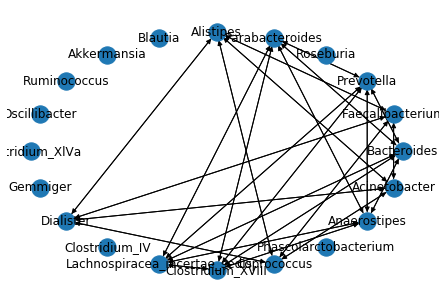

In [10]:
relation = pd.read_csv('control_causal/control_ematrix_2.csv', index_col=0, sep=',')
prior = pd.read_csv('control_causal/control_pmatrix_2.csv', index_col=0, sep=',')
edges = []
nodes = []
for target in relation.index:
    nodes.append(target)
    for source in relation.columns:
        if prior.loc[target, source]>=0.9 and target!=source:
            effect = 1.0 #1.0, abs(float(relation.loc[target, source]))
            edges.append((source, target, effect))
net=nx.DiGraph()
net.add_nodes_from(nodes)
net.add_weighted_edges_from(edges)
nx.draw_circular(net, with_labels=True)

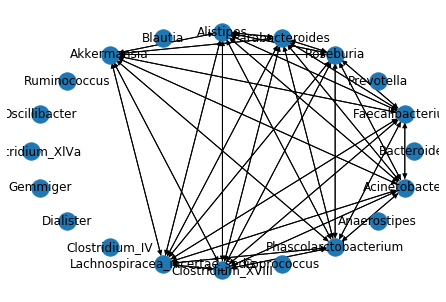

In [11]:
relation = pd.read_csv('cancer_causal/cancer_ematrix_2.csv', index_col=0, sep=',')
prior = pd.read_csv('cancer_causal/cancer_pmatrix_2.csv', index_col=0, sep=',')
edges = []
nodes = []
for target in relation.index:
    nodes.append(target)
    for source in relation.columns:
        if prior.loc[target, source]>=0.9 and target!=source:
            effect = 1.0 #1.0, abs(float(relation.loc[target, source]))
            edges.append((source, target, effect))
net=nx.DiGraph()
net.add_nodes_from(nodes)
net.add_weighted_edges_from(edges)
nx.draw_circular(net, with_labels=True)